In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
sns.set_style("whitegrid")
sns.set_context("poster")
color = sns.color_palette()
%matplotlib inline

Using TensorFlow backend.


### Kalman Filter with Parameters Estimated by EM

In [2]:
x = 0
T = 1000
y = []
for t in range(T):
    x = np.random.normal(x, 0.05)
    y.append(np.random.normal(x, 0.5))
y = np.array(y)

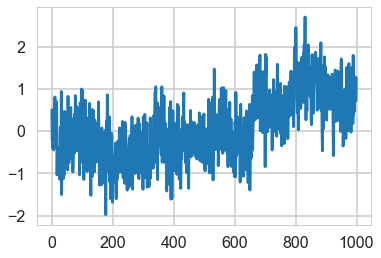

In [3]:
plt.plot(y)

In [4]:
def kalman_filter(y, sigma_eps, sigma_gamma, mu_init, sigma_init):
    T = len(y)
    mu = [mu_init]
    sigma = [sigma_init]
    for t in range(T):
        sigma.append(1 / (sigma[-1] + sigma_eps) + 1 / sigma_gamma)
        mu.append(mu[-1] + (sigma_eps + sigma[-1]) / (sigma_eps + sigma[-1] + sigma_gamma)*(y[t] -  mu[-1]))
        
    return mu, sigma

In [5]:
def kalman_smoother(y, x_filter, sigma_filter, sigma_eps, sigma_gamma):
    T = len(y)
    mu = [x_filter[-1]]
    sigma = [sigma_filter[-1]]
    for t in range(1, T + 1):
        mu.append(x_filter[T - t] + sigma_filter[T - t]/(sigma_filter[T - t] + sigma_eps) * (mu[-1] - x_filter[T - t]))
        sigma.append((sigma_filter[T - t]/(sigma_filter[T - t] + sigma_eps))**2 * sigma[-1] + sigma_filter[T-t]/(sigma_filter[T - t] + sigma_eps) * sigma_eps)
    return mu, sigma

In [6]:
def E_step(y, sigma_eps, sigma_gamma, mu_init, sigma_init):
    x_filter, sigma_filter = kalman_filter(y, sigma_eps, sigma_gamma, mu_init, sigma_init)
    x_smoother,_ = kalman_smoother(y, x_filter, sigma_filter, sigma_eps, sigma_gamma)
    
    return x_smoother[::-1], x_smoother[0]

In [7]:
def M_step(y, x_smoother):
    T = len(y)
    sigma_eps = sum((x_smoother[1:] - x_smoother[:T]) ** 2)/T
    sigma_gamma = sum((y - x_smoother[1:])**2)/(T + 1)
    return sigma_eps, sigma_gamma

In [8]:
def EM(y):
    sigma_eps_old = 0.01
    sigma_gamma_old = 0.1
    sigma_eps = 0.005
    sigma_gamma = 0.1
    mu_init = y[0]
    sigma_init = 0.01
    sigma_eps_ls = []
    sigma_gamma_ls = []
    while np.abs(sigma_eps_old - sigma_eps) > 1e-6 or np.abs(sigma_gamma_old - sigma_gamma) > 1e-6:
        sigma_eps_old = sigma_eps
        sigma_gamma_old = sigma_gamma
        x_smoother,mu_init = E_step(y, sigma_eps, sigma_gamma, mu_init, sigma_init)
        sigma_eps, sigma_gamma = M_step(y, np.array(x_smoother))
        sigma_eps_ls.append(sigma_eps)
        sigma_gamma_ls.append(sigma_gamma)
    
    return x_smoother, sigma_eps_ls, sigma_gamma_ls

In [9]:
x_smoother, sigma_eps_ls, sigma_gamma_ls = EM(y)

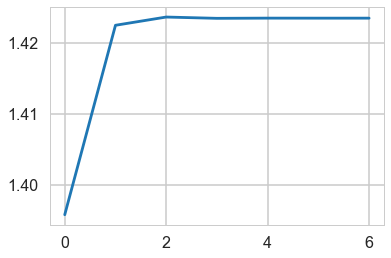

In [10]:
plt.plot(sigma_gamma_ls)

In [11]:
x_filter, sigma_filter = kalman_filter(y, 0.05, 0.5, y[0], 0.05)
x_smoother,_ = kalman_smoother(y, x_filter, sigma_filter, 0.05, 0.5)

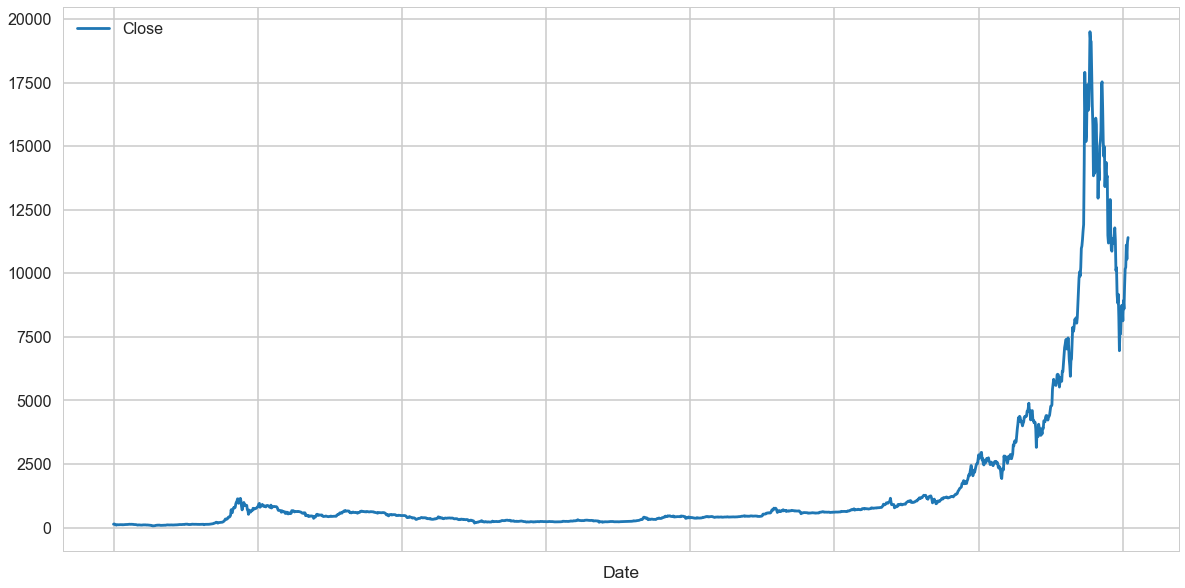

In [12]:
df = pd.read_csv('~/Documents/Spring 2018/AM 231/Final Project/cryptocurrencypricehistory-daily/bitcoin_price.csv')
df = df[::-1]
df.plot('Date', 'Close', figsize=(20,10))


In [13]:
price = df.Close.values
#price_ret = (price[1:] - price[:len(price) - 1]) / price[:len(price) - 1]
price_ret = np.log(price)

In [14]:
x_smoother, sigma_eps_ls, sigma_gamma_ls= EM(price_ret[:1500])

In [15]:
sigma_gamma_ls

[2.2381532837862386,
 2.8484482522417283,
 3.7443712534738443,
 3.6827550678762551,
 3.6868336902199572,
 3.686562744730205,
 3.6865807395132872,
 3.6865795443749168,
 3.686579623750927]

E[exp(X)]=exp(μ+σ2/2)

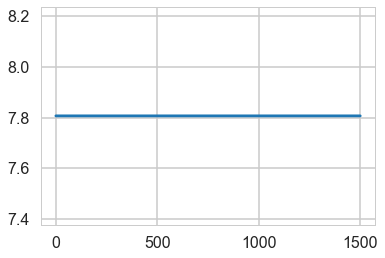

In [16]:
plt.plot(x_smoother[1:])

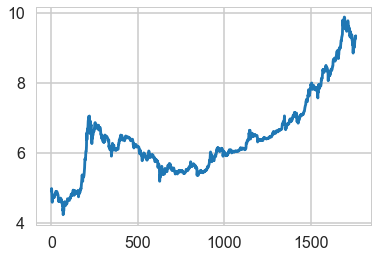

In [17]:
plt.plot(price_ret)

In [18]:
x_filter, sigma_filter = kalman_filter(price_ret[:1759], sigma_eps_ls[-1],  sigma_gamma_ls[-1], price_ret[0], sigma_gamma_ls[-1])

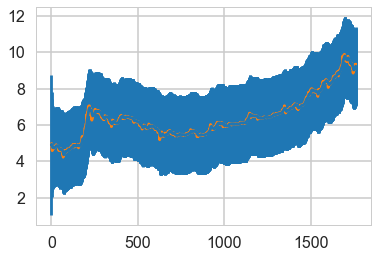

In [19]:
plt.errorbar(range(len(x_filter)), x_filter, yerr= 2 * np.sqrt(sigma_filter))
#plt.plot(price_ret[1000:1010])
plt.plot(price_ret[:1760])

In [20]:
np.sqrt(mean_squared_error(price_ret, x_filter))

0.072068795165417657

### Comparing with  LSTM

In [21]:
price_norm = price_ret.reshape(-1, 1)
# split into train and test sets
train_size = 1500
test_size = len(price_norm) - train_size
train, test = price_norm[0:train_size], price_norm[train_size:len(price)]
print(len(train), len(test))

1500 260


In [22]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [23]:
# convert an array of values into a dataset matrix
def create_dataset(price, look_back=1):
    X = []
    for i in range(look_back):
        X.append(price[i : i + len(price) - look_back])
    X.append(price[look_back: len(price)])
    return X

In [24]:
# reshape into X=t and Y=t+1
look_back = 1
train = create_dataset(train, look_back)
test = create_dataset(test, look_back)

In [25]:
trainX = train[0]
trainY = train[1]
testX = test[0]
testY = test[1]

In [26]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [27]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
 - 9s - loss: 0.0413
Epoch 2/10
 - 10s - loss: 0.0036
Epoch 3/10
 - 9s - loss: 1.7555e-04
Epoch 4/10
 - 9s - loss: 1.5916e-04
Epoch 5/10
 - 9s - loss: 1.6530e-04
Epoch 6/10
 - 8s - loss: 1.6223e-04
Epoch 7/10
 - 8s - loss: 1.6898e-04
Epoch 8/10
 - 8s - loss: 1.6540e-04
Epoch 9/10
 - 8s - loss: 1.6501e-04
Epoch 10/10
 - 8s - loss: 1.6533e-04


In [28]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [29]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.01 RMSE
Test Score: 0.07 RMSE
